# Import

In [124]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar

# DataBase Connection

In [125]:
conn = psycopg2.connect(
    host='hp-dev-db-12sep.cgitnjqny0tw.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='hp_read_user',
    password='hp_@_2023_321',
    database='postgres'
)

# Query to Fetch Data

In [126]:
query1 = """select created::date as order_date,
	id as order_id,
    order_amount as order_amount,
    user_id as user_id
    from sales_userorderdata
	"""

In [127]:
data = pd.read_sql(query1, conn)

C:\Users\CEPL\AppData\Local\Temp\ipykernel_11968\1861578803.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query1, conn)


In [128]:
data

,order_date,order_id,order_amount,user_id
0,2023-02-11,628147,177.00,18349
1,2020-09-16,281392,731.00,17772
2,2019-07-08,133026,3460.58,16544
3,2019-07-08,133033,317.31,12916
4,2019-07-08,133027,1612.44,11643
...,...,...,...,...
569426,2019-07-08,133020,55.34,16586
569427,2019-08-07,133538,218.07,17686
569428,2019-07-08,133021,84.24,13973
569429,2022-12-30,613145,1262.00,38867


In [129]:
# Date Filter
# data = data[data["order_date"] >= '2022-01-01']
# data = data[data["order_date"] <= '2022-12-31']

In [130]:
data['order_date'] = pd.to_datetime(data['order_date'])
data = data.sort_values('order_date')

# Top Customers

In [132]:
data_ltv = data.groupby(["user_id"]).agg(
    LTV=pd.NamedAgg(column="order_amount", aggfunc = 'sum'),
    OrderCount=pd.NamedAgg(column="order_id", aggfunc='nunique'),
    AOV=pd.NamedAgg(column="order_amount", aggfunc='mean')).reset_index()
data_ltv["LTVPercentage"] = data_ltv["LTV"]*100/data_ltv["LTV"].sum()
data_ltv = data_ltv[["user_id", "LTV", "LTVPercentage", "OrderCount", "AOV"]]

In [133]:
data_ltv

,user_id,LTV,LTVPercentage,OrderCount,AOV
0,1,74048.00,0.013140,106,698.566038
1,2,39350.54,0.006983,50,787.010800
2,3,8548.51,0.001517,22,388.568636
3,4,785.00,0.000139,1,785.000000
4,5,31302.22,0.005555,63,496.860635
...,...,...,...,...,...
31679,60589,1519.00,0.000270,1,1519.000000
31680,60595,1999.00,0.000355,15,133.266667
31681,60601,0.00,0.000000,3,0.000000
31682,60603,0.00,0.000000,7,0.000000


In [17]:
# top_10_highest_ltv = (data_ltv['LTV'].nlargest(10)).reset_index()
# top_10_highest_ltv.columns = ["user_id", "LTV"]
# bottom_10_non_zero_ltv = (data_ltv[data_ltv['LTV'] > 0]['LTV'].nsmallest(10)).reset_index()
# bottom_10_non_zero_ltv.columns = ["user_id", "LTV"]
# zero_ltv_users = (data_ltv[data_ltv['LTV'] == 0]['LTV']).reset_index()
# zero_ltv_users.columns = ["user_id", "LTV"]

In [18]:
# zero_ltv_users

# Customer Distribution

In [147]:
data_ltv_quartile=data_ltv.sort_values('LTV', ascending=False)
data_ltv_quartile['Mix']=data_ltv_quartile['LTV']*100/data_ltv_quartile['LTV'].sum()
data_ltv_quartile['CumuSum']=data_ltv_quartile['Mix'].cumsum()
data_ltv_quartile['LTVTag']=0
data_ltv_quartile.loc[data_ltv_quartile['CumuSum']<=25,"LTVTag"]='Top Customers'
data_ltv_quartile.loc[(data_ltv_quartile['CumuSum']>25) & (data_ltv_quartile['CumuSum']<=50),"LTVTag"]='Above Average Customers'
data_ltv_quartile.loc[(data_ltv_quartile['CumuSum']>50) & (data_ltv_quartile['CumuSum']<=75),"LTVTag"]='Below Average Customers'
data_ltv_quartile.loc[(data_ltv_quartile['CumuSum']>75) & (data_ltv_quartile['CumuSum']<=101),"LTVTag"]='Lagging Customers'

C:\Users\CEPL\AppData\Local\Temp\ipykernel_11968\2077773918.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Top Customers' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_ltv_quartile.loc[data_ltv_quartile['CumuSum']<=25,"LTVTag"]='Top Customers'


In [148]:
data_ltv_quartile

,user_id,LTV,LTVPercentage,OrderCount,AOV,Mix,CumuSum,LTVTag
148,720,13631095.30,2.418879,254,53665.729528,2.418879,2.418879,Top Customers
21067,41397,2372400.00,0.420989,55,43134.545455,0.420989,2.839868,Top Customers
2907,8953,2208856.16,0.391968,138,16006.204058,0.391968,3.231836,Top Customers
14928,31410,2050940.00,0.363945,204,10053.627451,0.363945,3.595782,Top Customers
152,752,1539618.94,0.273210,162,9503.820617,0.273210,3.868992,Top Customers
...,...,...,...,...,...,...,...,...
6299,15180,0.00,0.000000,1,0.000000,0.000000,100.000000,Lagging Customers
1971,7015,0.00,0.000000,1,0.000000,0.000000,100.000000,Lagging Customers
25625,49389,0.00,0.000000,1,0.000000,0.000000,100.000000,Lagging Customers
9721,21278,0.00,0.000000,1,0.000000,0.000000,100.000000,Lagging Customers


In [153]:
table = data_ltv_quartile.groupby('LTVTag').agg(
    CustomerCount=pd.NamedAgg(column='user_id', aggfunc='nunique'),
    AverageLTV=pd.NamedAgg(column='LTV', aggfunc='mean'),
    LTVPercentage=pd.NamedAgg(column='LTVPercentage', aggfunc='sum'),
    AverageOrderCount=pd.NamedAgg(column='OrderCount', aggfunc='mean'),
    AOV=pd.NamedAgg(column='AOV', aggfunc='mean')).reset_index()
table = table.reindex([3, 0, 1, 2]).reset_index().iloc[:, 1:]
table["CustomerPercentage"] = table["CustomerCount"]*100/table["CustomerCount"].sum()
table = table[["LTVTag", "CustomerCount", "CustomerPercentage", "AverageLTV", "LTVPercentage", "AverageOrderCount", "AOV"]]
table

,LTVTag,CustomerCount,CustomerPercentage,AverageLTV,LTVPercentage,AverageOrderCount,AOV
0,Top Customers,499,1.574927,282044.103006,24.974737,129.098196,3267.931652
1,Above Average Customers,1363,4.301856,103438.506691,25.018510,89.209098,1890.815938
2,Below Average Customers,3044,9.607373,46287.757106,25.003116,54.479961,1450.624458
3,Lagging Customers,26778,84.515844,5261.889274,25.003637,8.125401,923.388076


In [154]:
typemain = "Below Average Customers"
view = data_ltv_quartile[data_ltv_quartile["LTVTag"] == typemain]
view = view.sort_values('LTV', ascending = False)
view.head(10)[["user_id", "LTV", "LTVPercentage", "OrderCount", "AOV"]]
# view.tail(10)[["user_id", "LTV", "LTVPercentage", "OrderCount", "AOV"]]

,user_id,LTV,LTVPercentage,OrderCount,AOV
422,2543,73534.23,0.013049,41,1793.517805
22226,43410,73520.78,0.013046,32,2297.524375
10185,22191,73508.98,0.013044,51,1441.352549
5532,13950,73401.44,0.013025,47,1561.732766
22240,43437,73391.75,0.013024,46,1595.472826
4270,11639,73387.58,0.013023,67,1095.337015
2035,7151,73377.61,0.013021,87,843.420805
13735,29312,73343.05,0.013015,37,1982.244595
12756,27278,73336.88,0.013014,59,1242.997966
3358,9861,73288.20,0.013005,59,1242.172881


In [156]:
print(view.tail(10)[["user_id", "LTV", "LTVPercentage", "OrderCount", "AOV"]])

       user_id       LTV  LTVPercentage  OrderCount          AOV
6095     14870  29292.66       0.005198          24  1220.527500
404       2348  29269.57       0.005194          24  1219.565417
14203    30471  29265.00       0.005193          17  1721.470588
20397    40341  29264.00       0.005193          44   665.090909
4453     11964  29252.59       0.005191           3  9750.863333
161        820  29249.58       0.005190          18  1624.976667
3860     10887  29249.30       0.005190          35   835.694286
15663    32748  29239.25       0.005189          40   730.981250
8750     19526  29235.04       0.005188          17  1719.708235
5191     13345  29229.30       0.005187          10  2922.930000


# Single User Trend

In [157]:
# data['order_date'] = pd.to_datetime(data['order_date'])
# data['year'] = data['order_date'].dt.year
# data['month'] = data['order_date'].dt.month
# monthly_ltv = data.groupby(['user_id', 'year', 'month'])['order_amount'].sum().reset_index()

In [158]:
# user_id = 55

# user_data = monthly_ltv[monthly_ltv['user_id'] == user_id]

# # Create a column 'yearmonth' by combining 'year' and 'month'
# user_data['yearmonth'] = user_data['year'].astype(str) + user_data['month'].astype(str).str.zfill(2)

# # Convert 'yearmonth' to datetime
# user_data['yearmonth'] = pd.to_datetime(user_data['yearmonth'], format='%Y%m')

# # Plot 'yearmonth' vs. 'order_amount'
# plt.figure(figsize=(10, 6))
# plt.plot(user_data['yearmonth'], user_data['order_amount'], marker='o', linestyle='-')
# plt.title(f'Year-Month vs. Order Amount for User {user_id}')
# plt.xlabel('Year-Month')
# plt.ylabel('Order Amount')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Monthly LTV Trend

In [163]:
monthly_ltv = data.groupby([ data['order_date'].dt.to_period("M"), 'user_id'])['order_amount'].sum().reset_index()
monthly_avg_ltv = monthly_ltv.groupby("order_date")["order_amount"].mean().reset_index().rename(columns = {"order_amount": "Monthly_Average_LTV"})

In [164]:
monthly_avg_ltv

,order_date,Monthly_Average_LTV
0,2019-04,2103.896736
1,2019-05,1959.421311
2,2019-06,1853.115325
3,2019-07,2008.508804
4,2019-08,1890.772062
5,2019-09,1780.131317
6,2019-10,1792.911386
7,2019-11,1789.406787
8,2019-12,1868.861889
9,2020-01,1867.752514


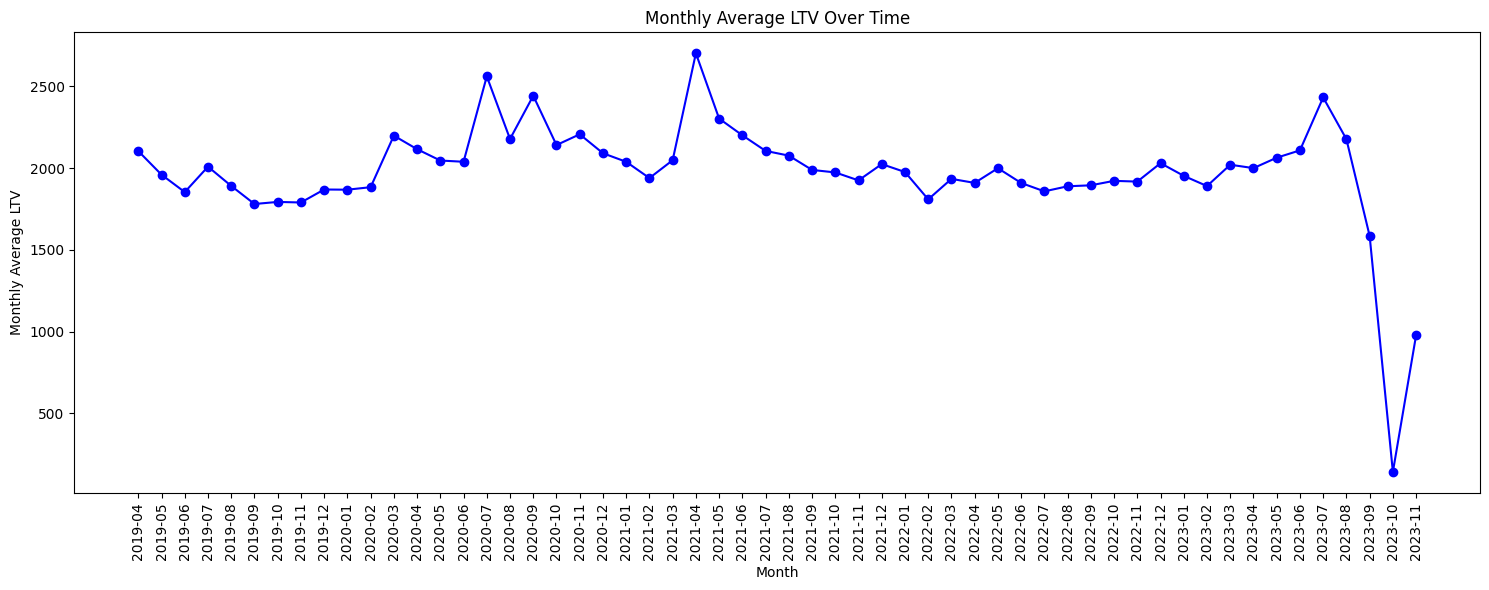

In [165]:
monthly_avg_ltv['order_date'] = monthly_avg_ltv['order_date'].dt.to_timestamp().dt.strftime("%Y-%m")
plt.figure(figsize=(15, 6))
plt.plot(monthly_avg_ltv['order_date'], monthly_avg_ltv['Monthly_Average_LTV'], marker='o', linestyle='-', color='b')
plt.xlabel('Month')
plt.ylabel('Monthly Average LTV')
plt.title('Monthly Average LTV Over Time')
plt.xticks(monthly_avg_ltv['order_date'], rotation=90)

plt.tight_layout()
plt.show()

In [96]:
# monthly_avg_ltv = monthly_ltv.groupby(["year", "month"]).agg(
#     avg_LTV = pd.NamedAgg(column = "order_amount", aggfunc = 'mean')).reset_index()

In [97]:
# monthly_avg_ltv['yearmonth'] = monthly_avg_ltv['year'].astype(str) + monthly_avg_ltv['month'].astype(str).str.zfill(2)

# # Convert 'yearmonth' to datetime
# monthly_avg_ltv['yearmonth'] = pd.to_datetime(monthly_avg_ltv['yearmonth'], format='%Y%m')

# Plot 'yearmonth' vs. 'avg_LTV'
plt.figure(figsize=(25, 6))
# plt.plot(monthly_avg_ltv['order_date'], monthly_avg_ltv['Monthly_Average_LTV'], marker='o', linestyle='-')
# plt.title('Year-Month vs. Average LTV')
# plt.xlabel('Year-Month')
# plt.ylabel('Average LTV')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# monthly_avg_ltv['order_date'] = monthly_avg_ltv['order_date'].dt.to_timestamp()
monthly_avg_ltv['order_date'] = pd.to_datetime(monthly_avg_ltv['order_date'], format='%Y%m')
plt.plot(monthly_avg_ltv['order_date'], monthly_avg_ltv['Monthly_Average_LTV'], marker='o', linestyle='-')
plt.xlabel('Order Date (Month)')
plt.ylabel('Monthly Average LTV')
plt.title('Monthly Average LTV Over Time')
plt.xticks(rotation=45)

# Show the plot
plt.show()

TypeError: Passing PeriodDtype data is invalid. Use `data.to_timestamp()` instead

<Figure size 2500x600 with 0 Axes>

In [93]:
monthly_avg_ltv

,order_date,Monthly_Average_LTV
0,2019-04-01,2103.896736
1,2019-05-01,1959.421311
2,2019-06-01,1853.115325
3,2019-07-01,2008.508804
4,2019-08-01,1890.772062
5,2019-09-01,1780.131317
6,2019-10-01,1792.911386
7,2019-11-01,1789.406787
8,2019-12-01,1868.861889
9,2020-01-01,1867.752514


In [17]:
# Alert
year = monthly_avg_ltv["year"].tolist()[-1]
month = monthly_avg_ltv["month"].tolist()[-1]
avg_LTV = monthly_avg_ltv["avg_LTV"].tolist()[-1]
year_6 = monthly_avg_ltv["year"].tolist()[-6]
month_6 = monthly_avg_ltv["month"].tolist()[-6]
LTV_6 = monthly_avg_ltv["avg_LTV"].tolist()[-6:]
avg_LTV_6 = sum(LTV_6) / len(LTV_6)
print(f"The average Life Time Value of Customers for the last month {year}-{month} is {avg_LTV}")
print(f"The average Life Time Value of Customers for the last 6 months {year_6}-{month_6} to {year}-{month} is {avg_LTV_6}")

The average Life Time Value of Customers for the last month 2023-10 is 141.33333333333334
The average Life Time Value of Customers for the last 6 months 2023-5 to 2023-10 is 1751.1529032896815
